In [47]:
from tensorflow.keras.applications.xception import Xception
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

In [48]:
BATCH_SIZE = 64
train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     )

test_generator = ImageDataGenerator()
train_data_dir="augmented/train"
test_data_dir="Datasets_divided/test"
val_data_dir="augmented/val"
image_size = 224
input_size = 224

class_names=os.listdir(train_data_dir)
class_names_test=os.listdir(test_data_dir)
print(class_names)
print(class_names_test)

['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
['Chickenpox', 'Measles', 'Monkeypox', 'Normal']


In [49]:
class_subset = sorted(os.listdir("augmented/train"))[:4] # Using only the first 10 classes

In [50]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size = BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(val_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


Found 2456 images belonging to 4 classes.
Found 300 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


In [51]:
def create_model(input_shape, n_classes, optimizer='rmsprop'):
    base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape)
    
    base_model.trainable = False
    
    top_model=base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    #top_model = Dense(1024, activation='relu')(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [52]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=4

n_steps = traingen.samples // BATCH_SIZE

n_val_steps = validgen.samples // BATCH_SIZE

n_epochs = 25
xception_model = create_model(input_shape, n_classes,optim_1)
xception_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_79 (Add)                   (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_78[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_79[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_82 (A

In [54]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

#EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


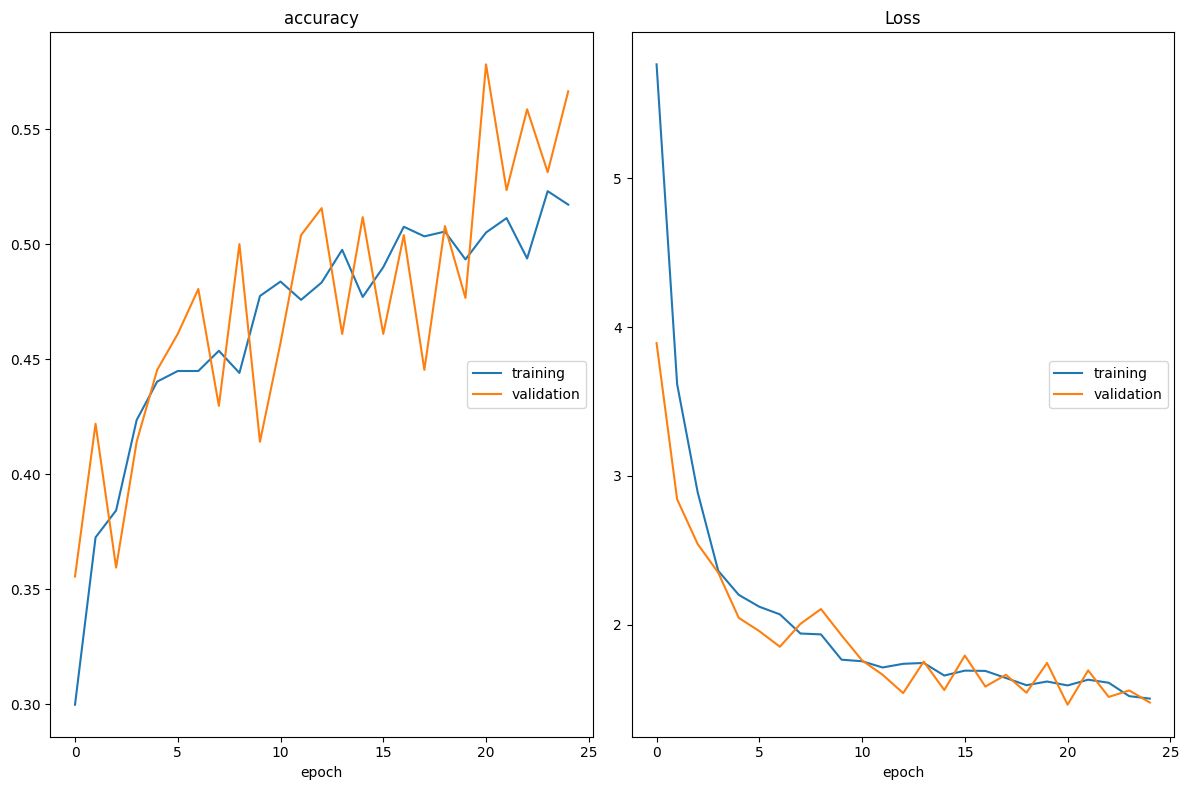

accuracy
	training         	 (min:    0.300, max:    0.523, cur:    0.517)
	validation       	 (min:    0.355, max:    0.578, cur:    0.566)
Loss
	training         	 (min:    1.503, max:    5.767, cur:    1.503)
	validation       	 (min:    1.462, max:    3.893, cur:    1.476)
38/38 [==============================] - 175s 5s/step - loss: 1.5028 - accuracy: 0.5171 - val_loss: 1.4764 - val_accuracy: 0.5664
CPU times: total: 7h 54min 54s
Wall time: 1h 12min 29s


In [55]:
%%time 

xception_history = xception_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [56]:
xception_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
xception_preds = xception_model.predict(testgen)
xception_pred_classes = np.argmax(xception_preds, axis=1)


81/81 [==============================] - 6s 63ms/step


In [57]:
xception_acc = accuracy_score(true_classes, xception_pred_classes)
print("Xception Model Accuracy: {:.2f}%".format(xception_acc * 100))

Xception Model Accuracy: 46.91%


In [58]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [59]:
f1 = f1_score(xception_pred_classes, true_classes, average='weighted')

print(classification_report(xception_pred_classes, true_classes, target_names=class_names))

              precision    recall  f1-score   support

  Chickenpox       0.08      0.17      0.11         6
     Measles       0.40      0.21      0.28        19
   Monkeypox       0.55      0.59      0.57        27
      Normal       0.57      0.59      0.58        29

    accuracy                           0.47        81
   macro avg       0.40      0.39      0.38        81
weighted avg       0.49      0.47      0.47        81



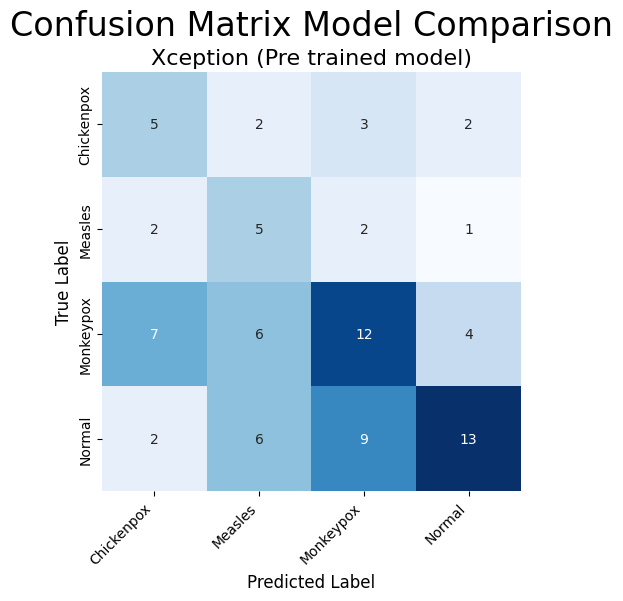

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report

class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, figsize=(15, 7))
  
plot_heatmap(true_classes, xception_pred_classes, class_names, ax1, title="Xception (Pre trained model)")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24,y=0.99)
fig.tight_layout(pad=8)
fig.subplots_adjust(top=.9)
plt.show()